# The EDA of DNS Response And Whois

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tldextract


# Known parking services‘ name server or cname
parking_services = ['sedoparking.com', 'namedrive.com', 'parked.com', 'whypark.com',\
                    'astoriacompany.com', 'fabulous.com', 'domainsponsor.com', 'trafficz.com',\
                    'domainhop.com', 'parkingdots.com', 'dotzup.com', 'voodoo.com', 'parkingcrew.com',\
                    'rookmedia.net', 'bodis.com', 'smartname.com', 'parklogic.com', 'domainapps.com', \
                    'trafficz.com', 'dopa.com', 'internettraffic.com', '1and1.com', 'namesilo.com', \
                    'above.com', 'dnsexit.com', 'ztomy.com', 'pql.net', 'airportparkingtucson.com', '1plus.net']


parking_services = list(map(lambda x:x.split(".")[0], parking_services))

## Step 1. Load Data

In [2]:
whois_files = []
dns_files = []
for f in os.listdir("./data"):
    if "dns" in f:
        dns_files.append(f)
    elif "DS_Store" in f:
        continue # pass the .DS_Store of macOS
    else:
        whois_files.append(f)

In [3]:
dns_list = []
whois_dict = {}

## Step 2. Parse Data Files

In [4]:
def _parse_dns_file(DNS_INFO):
    with open(DNS_INFO, mode='r') as f:
        for line in f:
            line = line.strip()
            domain, ns_str, cname_str = line.split(";")
            if domain == "":
                domain = np.nan
            if ns_str == "":
                ns_str = np.nan
            if cname_str == "":
                cname_str = np.nan
            dns_list.append((domain, ns_str, cname_str))
            
def _parse_whois_json(WHOIS_INFO):
    with open(WHOIS_INFO, mode='r') as f:
        try:
            for index, line in enumerate(f):
                domain, dict_str = line.strip().split("||")
                d = eval(dict_str)
                whois_dict[domain] = d
        except UnicodeDecodeError:
            print(WHOIS_INFO, index+1)

Load the dns files and whois files.

In [5]:
for f in dns_files:
    _parse_dns_file(os.path.join("./data", f))
for f in whois_files:
    _parse_whois_json(os.path.join("./data", f))

## Step 3. Check Whether Data Values Missing

### 3a. Check The Values of DNS

In [6]:
dns_df = pd.DataFrame(dns_list, columns=['domain', 'ns', 'cname'])
dns_df.head()

,domain,ns,cname
0,static.intsig.net,NaN,static.intsig.net.mcchcdn.com.
1,AV88AV.com,"june.ns.cloudflare.com.,ned.ns.cloudflare.com.",NaN
2,log.fangpaixinxi.com,NaN,NaN
3,lc-proxy-rtm.intviu.cn,NaN,NaN
4,m3.aw601.wsmm.bwoaa531.xyz,NaN,NaN


The number of missing value of 'ns' columns is 338162 
The number of missing value of 'cname' columns is 233429
Total number of DNS is 374283


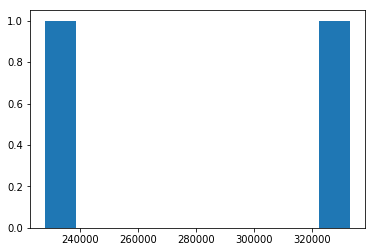

In [7]:
missing_value = dns_df.shape[0]-dns_df.count()
plt.hist(missing_value[1:],align='left')
print("The number of missing value of 'ns' columns is {} \nThe number of missing value of 'cname' columns is {}".format(missing_value['ns'],missing_value['cname']))
print("Total number of DNS is {}".format(dns_df.shape[0]))

### 3b. Check The Values of WHOIS

First, because of the different format of whois info, so we have to clean data.

In [8]:
import re
from datetime import datetime

def datetime_transform(string):
    result = []
    pattern = re.compile(r'datetime.datetime\((.*?)\)')
    for s in pattern.findall(string):
        time_items = s.split(",")
        for i in range(len(time_items)):
            time_items[i] = time_items[i].strip()
        if len(time_items) < 6:
            time_items+=['0' for i in range(6-len(time_items))]
        
        date = "-".join(time_items[:3])
        time = ":".join(time_items[3:6])
        
        new_string = date + " " + time
        try:
            result.append(datetime.strptime(new_string, '%Y-%m-%d %H:%M:%S'))
        except ValueError:
            result.append(np.nan)
    
    return result
    
def whois_transform(record):
    fqdn, whois_info = record
    if "info" in whois_info:
        return (fqdn, whois_info['name'], np.nan, np.nan, np.nan, np.nan, np.nan)
    else:
        if "datetime" in whois_info['creation_date']:
            creation_date = datetime_transform(whois_info['creation_date'])
        elif whois_info['creation_date'] == "None":
            creation_date = np.nan
        else:
            creation_date = whois_info['creation_date']
            
        if "datetime" in whois_info['expiration_date']:
            expiration_date = datetime_transform(whois_info['expiration_date'])
        elif whois_info['expiration_date'] == "None":
            expiration_date = np.nan
        else:
            expiration_date = whois_info['expiration_date']
        
        if "datetime" in whois_info['last_updated']:
            last_updated = datetime_transform(whois_info['last_updated'])
        elif whois_info['last_updated'] == "None":
            last_updated = np.nan
        else:
            last_updated = whois_info['last_updated']
            
        ns = None
        if whois_info['name_servers'] is None:
            ns = np.nan
        else:
            ns = whois_info['name_servers']
        
        return (fqdn, whois_info['name'], whois_info['registrar'], creation_date, expiration_date, last_updated, ns)

whois_list = list(map(whois_transform, whois_dict.items()))

In [9]:
whois_df = pd.DataFrame(whois_list, columns=['fqdn','query_name', 'registrar', 'creation_date', 'expiration_date', 'last_updated', 'ns'])
whois_df

,fqdn,query_name,registrar,creation_date,expiration_date,last_updated,ns
0,masdk.3g.qq.com,qq.com,"MarkMonitor, Inc.","[1995-05-04 04:00:00, 1995-05-03 21:00:00]","[2027-07-27 02:09:19, 2027-07-26 19:09:19]",NaN,"NS1.QQ.COM,NS2.QQ.COM,NS3.QQ.COM,NS4.QQ.COM,ns..."
1,sh.btfs.ftn.skeo.net,skeo.net,"Chengdu west dimension digital technology Co.,...","[2016-11-27 19:27:37, 2016-11-27 19:27:34]","[2019-11-27 19:27:37, 2019-11-27 19:27:34]",NaN,"NS1.CLOUDCDNS.COM,NS2.CLOUDCDNS.COM,ns1.cloudc..."
2,hupu-i1i5.img-cn-hangzhou.aliyuncs.com,aliyuncs.com,"Alibaba Cloud Computing (Beijing) Co., Ltd.",2012-04-01 07:23:40,2021-04-01 07:23:40,NaN,"NS3.ALIYUN.COM,NS4.ALIYUN.COM,NS5.ALIYUN.COM"
3,mirror.qiniu.mafengwo.net,mafengwo.net,"Alibaba Cloud Computing (Beijing) Co., Ltd.",2006-01-06 01:51:27,2023-01-06 01:51:27,NaN,"VIP1.ALIDNS.COM,VIP2.ALIDNS.COM"
4,google.com,google.com,"MarkMonitor, Inc.","[1997-09-15 04:00:00, 1997-09-15 00:00:00]","[2020-09-14 04:00:00, 2020-09-13 21:00:00]",NaN,"NS1.GOOGLE.COM,NS2.GOOGLE.COM,NS3.GOOGLE.COM,N..."
5,staticsrc.ysbang.cn,ysbang.cn,阿里云计算有限公司（万网）,NaN,NaN,NaN,"vip1.alidns.com,vip2.alidns.com"
6,m.igetget.com,igetget.com,"Alibaba Cloud Computing (Beijing) Co., Ltd.",2015-06-08 05:44:23,2021-06-08 05:44:23,NaN,"VIP1.ALIDNS.COM,VIP2.ALIDNS.COM"
7,online.kugou.com,online.kugou.com,NaN,NaN,NaN,NaN,NaN
8,update.sdk.jiguang.cn,jiguang.cn,阿里云计算有限公司（万网）,NaN,NaN,NaN,"ns3.dnsv4.com,ns4.dnsv4.com"
9,omgup.xiaojukeji.com,xiaojukeji.com,"Alibaba Cloud Computing (Beijing) Co., Ltd.",2012-06-04 16:55:19,2020-06-04 16:55:19,NaN,"NS1.DIDIWUXIAN.COM,NS2.DIDIWUXIAN.COM,NS3.DIDI..."


 The total number of record is 374211
 The number of missing value of 'registrar' is 179666
 The number of missing value of 'creation_date' is 198314
 The number of missing value of 'expiration_date' is 198165
 The number of missing value of 'last_updated' is 362203
 The number of missing value of 'ns' is 182202


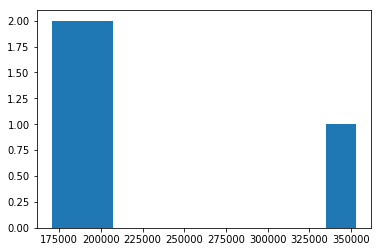

In [10]:
whois_missing = whois_df.shape[0]-whois_df.count()
plt.hist(whois_missing[2:],align='left')
print(" The total number of record is {}\n \
The number of missing value of 'registrar' is {}\n \
The number of missing value of 'creation_date' is {}\n \
The number of missing value of 'expiration_date' is {}\n \
The number of missing value of 'last_updated' is {}\n \
The number of missing value of 'ns' is {}".format(whois_df.shape[0],
                                                 whois_missing['registrar'],
                                                 whois_missing['creation_date'],
                                                 whois_missing['expiration_date'],
                                                 whois_missing['last_updated'],
                                                 whois_missing['ns']))

 It looks like losing lots of information.

## Step 4.Filter The Crawled Name Server And CNAME Using Known List 

In [11]:
def check_ns_cname(df, data_type='dns'):
    parking_domain = []
    for row in df.itertuples(index=True):
        if getattr(row, "ns") is not np.nan:
            ns_str = getattr(row, "ns").split(",")
            ns_list = list(map(lambda x:x.rstrip('.'), ns_str))
            unique_domain = set()
            for ns in ns_list:  # iterate ns_list
                ext = tldextract.extract(ns)
                unique_domain.update([ext.domain])

            for ns in unique_domain: # iterate unique_domain
                if ns in parking_services:
                    if data_type=='dns':
                        parking_domain.append((getattr(row, "domain"), getattr(row, "ns"), getattr(row, "cname")))
                        break
                    else:
                        parking_domain.append((getattr(row, "fqdn"), getattr(row, "ns")))
                        break
                        
    if data_type == 'dns':
        park_df = pd.DataFrame(parking_domain, columns=['domain','ns', 'cname'])
    else:
        park_df = pd.DataFrame(parking_domain, columns=['domain','ns'])
    del parking_domain
    return park_df

park_df = check_ns_cname(dns_df)
park_df

,domain,ns,cname
0,www.gzrail.com.cn,"ns1.parkingcrew.net.,ns2.parkingcrew.net.",NaN
1,www.lifanku.co,"ns3.parklogic.com.,ns1.parklogic.com.,ns5.park...",lifanku.co.
2,javzoo.org,"ns2.parklogic.com.,ns3.parklogic.com.,ns1.park...",NaN
3,sh.k6p.co,"ns3.above.com.,ns4.above.com.",NaN
4,petite-une-deux-trois.com,"ns2.parklogic.com.,ns4.parklogic.com.,ns3.park...",NaN
5,popunderjs.club,"ns1.parkingcrew.net.,ns2.parkingcrew.net.",NaN
6,888.zznzyy.com,"sk.s5.ans1.ns148.ztomy.com.,sk.s5.ans2.ns148.z...",NaN
7,api.tranzz.com,"ns5.parklogic.com.,ns1.parklogic.com.,ns3.park...",tranzz.com.
8,chap.ga,"ns2.parkingcrew.net.,ns1.parkingcrew.net.",NaN
9,cjmaniacs.com,"ns1.above.com.,ns2.above.com.",NaN


### Add the parking domain's cname into known parking services list

In [12]:
park_cname_list = []
for row in park_df.itertuples(index=True):
    if getattr(row, "cname") is not np.nan:
        park_cname_list.append(getattr(row, "cname").lower().strip('.'))
parking_services += park_cname_list
parking_services = list(set(parking_services))
parking_services = list(map(lambda x:tldextract.extract(x).domain, parking_services))

## Step 5. Filter WHOIS Data Using Known List 

### 5a. Filter the *name servers*

In [13]:
parking_services
whois_park_df = check_ns_cname(whois_df,data_type='whois')
whois_park_df

,domain,ns
0,www.javocado.org,"NS1.PARKINGCREW.NET,NS2.PARKINGCREW.NET,ns1.pa..."
1,bbs.wai3.com,"NS1626.ZTOMY.COM,NS2626.ZTOMY.COM,ns1626.ztomy..."
2,www.chilidawgsoftware.com,"NS1626.ZTOMY.COM,NS2626.ZTOMY.COM,ns1626.ztomy..."
3,whotmail.com,"NS1.ABOVE.COM,NS2.ABOVE.COM,ns1.above.com,ns2...."
4,91sp.v3p.co,"ns1.parkingcrew.net,ns2.parkingcrew.net"
5,homtai.com,"NS111373.ZTOMY.COM,NS211373.ZTOMY.COM,ns111373..."
6,www.frombar.com,"NS1.PARKINGCREW.NET,NS2.PARKINGCREW.NET,ns1.pa..."
7,dadebehring.com,"NS1.PARKINGCREW.NET,NS2.PARKINGCREW.NET,ns1.pa..."
8,mzdi.com,"NS1.PARKINGCREW.NET,NS2.PARKINGCREW.NET,ns1.pa..."
9,chinamoblie.com,"NS1.PARKLOGIC.COM,NS2.PARKLOGIC.COM,NS3.PARKLO..."


In [14]:
total_park = pd.concat([park_df, whois_park_df])
total_park.drop_duplicates(['domain'])

/Users/roger/Software/miniconda3/envs/park/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,cname,domain,ns
0,NaN,www.gzrail.com.cn,"ns1.parkingcrew.net.,ns2.parkingcrew.net."
1,lifanku.co.,www.lifanku.co,"ns3.parklogic.com.,ns1.parklogic.com.,ns5.park..."
2,NaN,javzoo.org,"ns2.parklogic.com.,ns3.parklogic.com.,ns1.park..."
3,NaN,sh.k6p.co,"ns3.above.com.,ns4.above.com."
4,NaN,petite-une-deux-trois.com,"ns2.parklogic.com.,ns4.parklogic.com.,ns3.park..."
5,NaN,popunderjs.club,"ns1.parkingcrew.net.,ns2.parkingcrew.net."
6,NaN,888.zznzyy.com,"sk.s5.ans1.ns148.ztomy.com.,sk.s5.ans2.ns148.z..."
7,tranzz.com.,api.tranzz.com,"ns5.parklogic.com.,ns1.parklogic.com.,ns3.park..."
8,NaN,chap.ga,"ns2.parkingcrew.net.,ns1.parkingcrew.net."
9,NaN,cjmaniacs.com,"ns1.above.com.,ns2.above.com."


## Step 6.Count the most frequent second-level domain of service=2 domain

In [18]:
from collections import Counter
import tldextract

def count_most_frequent(filename):

    fqdn = list()

    with open(filename, mode="r") as f:
        for line in f:
            fqdn.append(line.strip())

    tld = list()
    second_level_name = list()
    third_level_name = list()

    for domain_name in fqdn:
        second_level_name.append(tldextract.extract(domain_name).domain)

    return Counter(second_level_name).most_common(n=50)
    
count_most_frequent('service2.txt')

[('yy', 216),
 ('pakpark', 45),
 ('go', 30),
 ('chinairn', 29),
 ('cc', 14),
 ('xiaojiaoyu100', 13),
 ('booking', 10),
 ('ft', 9),
 ('99yp', 7),
 ('depcloud', 6),
 ('1337x', 5),
 ('teesoft', 5),
 ('chaojibiaoge', 5),
 ('tntgame', 5),
 ('surveymonkey', 5),
 ('xosapk', 4),
 ('kancha', 4),
 ('jinmi', 4),
 ('samsungallstore', 4),
 ('intra-gnn', 4),
 ('gametoma', 4),
 ('bokecc', 3),
 ('dh4567', 3),
 ('ks-cdn', 3),
 ('dopa', 3),
 ('FILBA', 3),
 ('edubt', 3),
 ('basememlog', 3),
 ('sygic', 3),
 ('sparklingsociety', 3),
 ('hdwing', 3),
 ('qlauncher', 3),
 ('raychou', 3),
 ('yn47', 3),
 ('4399tgzt', 2),
 ('61678', 2),
 ('tzyee', 2),
 ('mofa', 2),
 ('abc-kemeja', 2),
 ('trello', 2),
 ('btdd2015', 2),
 ('erototoxdecodings', 2),
 ('fastcon', 2),
 ('fafa6', 2),
 ('faxingfeng', 2),
 ('865p', 2),
 ('hotpornpics', 2),
 ('itHx', 2),
 ('jzdzhibo', 2),
 ('m27bao', 2)]

In [20]:
parking_services += ['pakpark','99yp','depcloud','1337x','teesoft','tntgame','xosapk','gametoma','bokecc',
                    'dh4567','dopa','filba','edubt','hdwing','raychou','yn47','4399tgzt','61678','tzyee',
                    'btdd2015','fafa6','faxingfeng','865p','hotpornpics','itHx','m27bao','jzdzhibo','btscene',
                     'baixuefeng','mppnj','9iwp','gjthub','getphoto.net','1004j','iphonerm','33483','sanya30',
                    '16e7']
parking_services = list(set(parking_services))

In [29]:
# Load the data of 300w domain
domain_300w = pd.read_csv("../domain_dataset/domain300w.txt")
domain_300w.columns = ['sip','domain','type','ttl','cnametype','ns']
domain_300w.drop(columns=['sip','type','ttl','cnametype'])

,domain,ns
0,sh.btfs.ftn.skeo.net,sh.btfs.ftn.qq.com
1,hupu-i1i5.img-cn-hangzhou.aliyuncs.com,112.124.225.173
2,mirror.qiniu.mafengwo.net,7xi9ea.src.com.z0.glb.qiniudns.com;223.112.103...
3,google.com,216.58.200.238
4,staticsrc.ysbang.cn,58.67.206.7
5,m.igetget.com,2s9hdex040x65o42.alicloudsec.com;118.178.213.11
6,online.kugou.com,183.232.71.203;183.232.71.196;183.232.70.194;1...
7,update.sdk.jiguang.cn,183.240.12.32;183.240.12.33
8,omgup.xiaojukeji.com,gz01.router.omg.xiaojukeji.com;123.207.209.54;...
9,guzzoni.apple.com,origin.guzzoni-apple.com.akadns.net;17.250.9.5


In [30]:
def check_domain(df):
    parking_domain = []
    for row in df.itertuples(index=True):
        ext = tldextract.extract(getattr(row, 'domain'))

        if ext.domain in parking_services:
                parking_domain.append((getattr(row, "domain"), getattr(row, "ns")))

    park_df = pd.DataFrame(parking_domain, columns=['domain','ns'])
    
    del parking_domain
    return park_df
domain_300w_park_df = check_domain(domain_300w)
domain_300w_park_df

,domain,ns
0,imedia.bokecc.com,imedia.bokecc.com.wswebcdn.com;112.51.121.177
1,olcfg.1plus.io,elb-olcfg-262421780.ap-southeast-1.elb.amazona...
2,union.bokecc.com,union.bokecc.com.wswebcdn.com;112.51.121.177
3,nc30.pakpark.cn,a543cde7.pakpark.cn.cname.yunduncname.com;27.1...
4,tzyee.net,54.72.9.51
5,cm14-ccm1-2.play.bokecc.com,play.bokecc185.bokecs.net;183.232.237.105;183....
6,genesis.1337x.org,162.210.199.85
7,p.bokecc.com,p.bokecc.com.wswebcdn.com;183.240.52.140
8,bd1.dopa.com,bd1.dopa.com.cname2087.yjs-cdn.com;112.13.72.131
9,ca14-cca1-1.play.bokecc.com,play.bokecc421.bokecs.net;183.232.237.104;183....


In [31]:
parking_services

['zhongzigou',
 'xosapk',
 'feedsportal',
 'above',
 'raychou',
 'kb2300',
 'asklinks',
 'kqtipi',
 '1and1',
 '9iwp',
 'centerfold-babes',
 '61678',
 'dopa',
 'jzdzhibo',
 'namedrive',
 'isexys',
 'wofei',
 'fulladultclips',
 '99yp',
 'xiumima',
 'm27bao',
 'pulsargamesoft',
 'btscene',
 'tzyee',
 'gzpc',
 '333bpp',
 '2epub',
 'japansexteen',
 'iphonerm',
 'worldwidemobi',
 'namesilo',
 'vod50',
 'pswbook',
 'parkingdots',
 'ztomy',
 'xsdd',
 'pakpark',
 'wuyuexiang888',
 'bokecc',
 'gybzyz',
 'hotpornpics',
 'astoriacompany',
 '1004j',
 'avlang7',
 'xvideosapp',
 'proboards40',
 'depcloud',
 'fabulous',
 'gametoma',
 'bitebt',
 'dnads',
 'tortuga-cove',
 'pltraffic3',
 '5avlib',
 'confsearch',
 'xiegeboke',
 'vzcmall',
 'domainsponsor',
 'dh4567',
 '23nr',
 'filba',
 'gzxydl',
 'internettraffic',
 'urt-tv',
 'sexmoviexxx',
 'piratepublic',
 'ksa83i',
 'porn17sex',
 'acbfds',
 'zhaonima',
 'sedoparking',
 'eroacg',
 'trafficz',
 'fapforfun',
 'ixiee',
 'bodis',
 'btcherry',
 '998911',


In [32]:
total_park = pd.concat([total_park, domain_300w_park_df])
total_park.drop_duplicates(['domain'])

/Users/roger/Software/miniconda3/envs/park/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,cname,domain,ns
0,NaN,www.gzrail.com.cn,"ns1.parkingcrew.net.,ns2.parkingcrew.net."
1,lifanku.co.,www.lifanku.co,"ns3.parklogic.com.,ns1.parklogic.com.,ns5.park..."
2,NaN,javzoo.org,"ns2.parklogic.com.,ns3.parklogic.com.,ns1.park..."
3,NaN,sh.k6p.co,"ns3.above.com.,ns4.above.com."
4,NaN,petite-une-deux-trois.com,"ns2.parklogic.com.,ns4.parklogic.com.,ns3.park..."
5,NaN,popunderjs.club,"ns1.parkingcrew.net.,ns2.parkingcrew.net."
6,NaN,888.zznzyy.com,"sk.s5.ans1.ns148.ztomy.com.,sk.s5.ans2.ns148.z..."
7,tranzz.com.,api.tranzz.com,"ns5.parklogic.com.,ns1.parklogic.com.,ns3.park..."
8,NaN,chap.ga,"ns2.parkingcrew.net.,ns1.parkingcrew.net."
9,NaN,cjmaniacs.com,"ns1.above.com.,ns2.above.com."
